# Tensorflow Recommenders - Implementation on Retail Data
> TFRS Retrieval, ranking, time and text feature embeddings, and multi-task modeling on Olist retail dataset

- toc: true
- badges: true
- comments: true
- categories: [TFRS, Tensorflow, Retail, Olist, MultiTask]
- author: "<a href='https://github.com/fickaz/TFRS-on-Retail-Data/tree/main'>Taufik Azri</a>"
- image:

## Introduction

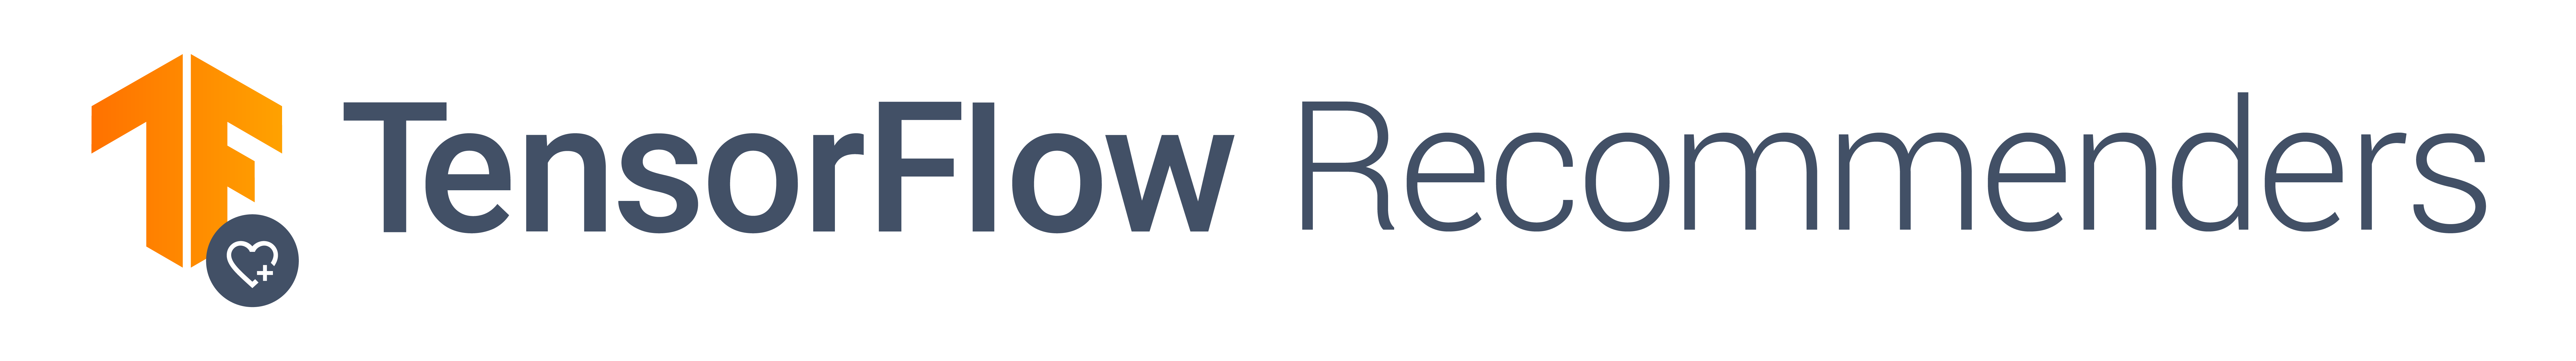

### Overview
- Objective: To demonstrate TensorFlow 2.0 TFRS recommenders library to build a recommendation system on a customer retail data.
- Data source: https://www.kaggle.com/olistbr/brazilian-ecommerce/home/
- Benefit: Flexible model, ability to add different features and specify and adjust model complexity easily.

### Theory
Two types of recommendation model-- Retrieval and Ranking.
- Retrieval: The retrieval stage is responsible for selecting an initial set of hundreds of candidates from all possible candidates. The main objective of this model is to efficiently weed out all candidates that the user is not interested in. Because the retrieval model may be dealing with millions of candidates, it has to be computationally efficient. Retrieval can be computationally more efficient because it only returns smaller set of items a user would strongly interested.
- Ranking: The ranking stage takes the outputs of the retrieval model and fine-tunes them to select the best possible handful of recommendations. Its task is to narrow down the set of items the user may be interested in to a shortlist of likely candidates.

Built with TensorFlow 2.x, TFRS makes it possible to:

- Build and evaluate flexible **[candidate nomination models](https://research.google/pubs/pub48840/)**;
- Freely incorporate item, user, and context **[information](https://tensorflow.org/recommenders/examples/featurization)** into recommendation models;
- Train **[multi-task models](https://tensorflow.org/recommenders/examples/multitask)** that jointly optimize multiple recommendation objectives;
- Efficiently serve the resulting models using **[TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving)**.
- [Multi-task learning](https://research.google/pubs/pub47842/), [feature cross modeling](https://arxiv.org/abs/1708.05123), [self-supervised learning](https://arxiv.org/abs/2007.12865), and state-of-the-art efficient [approximate nearest neighbours computation](https://ai.googleblog.com/2020/07/announcing-scann-efficient-vector.html).

### Outline
1. Retrieval model
2. Ranking model
3. Adding text and timestamp embedding
4. Multitask recommendation, combining retrieval and ranking
5. Add more features using Cross Network.

## Setup

In [1]:
!pip install -q tensorflow-recommenders

     |████████████████████████████████| 81kB 10.2MB/s 


In [2]:
import os
import pprint
import tempfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from typing import Dict, Text

import tensorflow as tf
import tensorflow_recommenders as tfrs

## Data Loading

In [3]:
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d olistbr/brazilian-ecommerce

     |████████████████████████████████| 61kB 8.7MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=bf15ed07504f79639fef7510f8de240bd016dc7b3eb7a438c51c620c4a562799
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
 47% 20.0M/42.7M [00:00<00:00, 90.6MB/s]
100% 42.7M/42.7M [00:00<00:00, 153MB/s] 


In [4]:
!unzip brazilian-ecommerce.zip

Archive:  brazilian-ecommerce.zip
  inflating: olist_customers_dataset.csv  
  inflating: olist_geolocation_dataset.csv  
  inflating: olist_order_items_dataset.csv  
  inflating: olist_order_payments_dataset.csv  
  inflating: olist_order_reviews_dataset.csv  
  inflating: olist_orders_dataset.csv  
  inflating: olist_products_dataset.csv  
  inflating: olist_sellers_dataset.csv  
  inflating: product_category_name_translation.csv  


In [8]:
import glob
files = sorted(glob.glob('/content/*.csv'))
dfs = [pd.read_csv(data) for data in files]
for i, x in enumerate(dfs):
  print(f"\n\ndfs {i}: {files[i].split('/')[-1].split('.')[0]}\n")
  display(x.head())



dfs 0: olist_customers_dataset



,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP




dfs 1: olist_geolocation_dataset



,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP




dfs 2: olist_order_items_dataset



,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14




dfs 3: olist_order_payments_dataset



,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45




dfs 4: olist_order_reviews_dataset



,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53




dfs 5: olist_orders_dataset



,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00




dfs 6: olist_products_dataset



,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0




dfs 7: olist_sellers_dataset



,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP




dfs 8: product_category_name_translation



,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


## Data Preparation

In [38]:
df11 = pd.merge(dfs[2], dfs[5], how='outer', on='order_id')[['product_id','customer_id','order_purchase_timestamp']]
df12 = pd.merge(dfs[6], dfs[8], how='left', on='product_category_name')[['product_id','product_category_name_english']]
df1 = pd.merge(df11, df12, how='left', on='product_id')
df1['sku'] = df1.groupby(['product_category_name_english']).cumcount().astype('str')
df1['product_id'] = df1['product_category_name_english'] + '_' + df1['sku']
df1['implicit_interaction_weight'] = 1
df1['order_purchase_timestamp'] = df1['order_purchase_timestamp'].map(lambda x: pd.to_datetime(x).timestamp())
df1 = df1[['customer_id', 'product_id', 'implicit_interaction_weight', 'order_purchase_timestamp']]
df1.columns = ['USERID','ITEMID','RATING','TIMESTAMP']
df1.dropna(inplace=True)
df1

,USERID,ITEMID,RATING,TIMESTAMP
0,3ce436f183e68e07877b285a838db11a,cool_stuff_0,1,1.505293e+09
1,f6dd3ec061db4e3987629fe6b26e5cce,pet_shop_0,1,1.493204e+09
2,6489ae5e4333f3693df5ad4372dab6d3,furniture_decor_0,1,1.515940e+09
3,d4eb9395c8c0431ee92fce09860c5a06,perfumery_0,1,1.533722e+09
4,58dbd0b2d70206bf40e62cd34e84d795,garden_tools_0,1,1.486217e+09
...,...,...,...,...
112645,b51593916b4b8e0d6f66f2ae24f2673d,housewares_6963,1,1.524492e+09
112646,84c5d4fbaf120aae381fad077416eaa0,computers_accessories_7825,1,1.531564e+09
112647,29309aa813182aaddc9b259e31b870e6,sports_leisure_8640,1,1.508778e+09
112648,b5e6afd5a41800fdf401e0272ca74655,computers_accessories_7826,1,1.502752e+09


In [10]:
interactions_dict = df1.groupby(['USERID', 'ITEMID'])['RATING'].count().reset_index()
interactions_dict = {name: np.array(value) for name, value in interactions_dict.items()}
interactions = tf.data.Dataset.from_tensor_slices(interactions_dict)

for x in interactions.take(5): print(x)

interactions = interactions.map(lambda x: {
    'USERID' : x['USERID'], 
    'ITEMID' : x['ITEMID'], 
    'RATING' : float(x['RATING']),
})

{'USERID': <tf.Tensor: shape=(), dtype=string, numpy=b'00012a2ce6f8dcda20d059ce98491703'>, 'ITEMID': <tf.Tensor: shape=(), dtype=string, numpy=b'toys_1531'>, 'RATING': <tf.Tensor: shape=(), dtype=int64, numpy=1>}
{'USERID': <tf.Tensor: shape=(), dtype=string, numpy=b'000161a058600d5901f007fab4c27140'>, 'ITEMID': <tf.Tensor: shape=(), dtype=string, numpy=b'health_beauty_6074'>, 'RATING': <tf.Tensor: shape=(), dtype=int64, numpy=1>}
{'USERID': <tf.Tensor: shape=(), dtype=string, numpy=b'0001fd6190edaaf884bcaf3d49edf079'>, 'ITEMID': <tf.Tensor: shape=(), dtype=string, numpy=b'baby_571'>, 'RATING': <tf.Tensor: shape=(), dtype=int64, numpy=1>}
{'USERID': <tf.Tensor: shape=(), dtype=string, numpy=b'0002414f95344307404f0ace7a26f1d5'>, 'ITEMID': <tf.Tensor: shape=(), dtype=string, numpy=b'cool_stuff_1263'>, 'RATING': <tf.Tensor: shape=(), dtype=int64, numpy=1>}
{'USERID': <tf.Tensor: shape=(), dtype=string, numpy=b'000379cdec625522490c315e70c7a9fb'>, 'ITEMID': <tf.Tensor: shape=(), dtype=strin

In [11]:
items_dict = df1[['ITEMID']].drop_duplicates()
items_dict = {name: np.array(value) for name, value in items_dict.items()}
items = tf.data.Dataset.from_tensor_slices(items_dict)

items = items.map(lambda x: x['ITEMID'])

In [12]:
### get unique item and user id's as a lookup table
unique_item_titles = np.unique(np.concatenate(list(items.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(interactions.batch(1_000).map(lambda x: x["USERID"]))))

# Randomly shuffle data and split between train and test.
tf.random.set_seed(42)
shuffled = interactions.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(60_000)
test = shuffled.skip(60_000).take(20_000)

## Retrieval Model

There are five important component of the query and candicate tower: candidate model (item_model), querty model (user_model), metrics, task, and compute loss.

In [13]:
class RetailModel(tfrs.Model):

    def __init__(self, user_model, item_model):
      super().__init__()
      
      ### Candidate model (item)
      ### This is Keras preprocessing layers to first convert user ids to integers, 
      ### and then convert those to user embeddings via an Embedding layer. 
      ### We use the list of unique user ids we computed earlier as a vocabulary:
      item_model = tf.keras.Sequential([
                                      tf.keras.layers.experimental.preprocessing.StringLookup(
                                      vocabulary=unique_item_titles, mask_token=None),
                                      tf.keras.layers.Embedding(len(unique_item_titles) + 1, embedding_dimension)
                                      ])
      ### we pass the embedding layer into item model
      self.item_model: tf.keras.Model = item_model
          
      ### Query model (users)    
      user_model = tf.keras.Sequential([
                                      tf.keras.layers.experimental.preprocessing.StringLookup(
                                      vocabulary=unique_user_ids, mask_token=None),
                                      # We add an additional embedding to account for unknown tokens.
                                      tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
                                      ])
      self.user_model: tf.keras.Model = user_model
      
      ### for retrieval model. we take top-k accuracy as metrics
      metrics = tfrs.metrics.FactorizedTopK(candidates=items.batch(128).map(item_model))
      
      # define the task, which is retrieval
      task = tfrs.tasks.Retrieval(metrics=metrics)
      
      self.task: tf.keras.layers.Layer = task

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
      # We pick out the user features and pass them into the user model.
      user_embeddings = self.user_model(features["USERID"])
      # And pick out the movie features and pass them into the movie model,
      # getting embeddings back.
      positive_movie_embeddings = self.item_model(features["ITEMID"])

      # The task computes the loss and the metrics.
      return self.task(user_embeddings, positive_movie_embeddings)

In [14]:
### Fitting and evaluating

### we choose the dimensionality of the query and candicate representation.
embedding_dimension = 32

## we pass the model, which is the same model we created in the query and candidate tower, into the model
item_model = tf.keras.Sequential([
                                tf.keras.layers.experimental.preprocessing.StringLookup(
                                vocabulary=unique_item_titles, mask_token=None),
                                tf.keras.layers.Embedding(len(unique_item_titles) + 1, embedding_dimension)
                                ])

user_model = tf.keras.Sequential([
                                tf.keras.layers.experimental.preprocessing.StringLookup(
                                vocabulary=unique_user_ids, mask_token=None),
                                # We add an additional embedding to account for unknown tokens.
                                tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
                                ])

model = RetailModel(user_model, item_model)

# a smaller learning rate may make the model move slower and prone to overfitting, so we stick to 0.1
# other optimizers, such as SGD and Adam, are listed here https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

## fit the model with ten epochs
model_hist = model.fit(cached_train, epochs=10)

#evaluate the model
model.evaluate(cached_test, return_dict=True)

Epoch 1/10
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
8/8 [==============================] - 400s 49s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 1.6667e-05 - factorized_top_k/top_10_categorical_accuracy: 6.6667e-05 - factorized_top_k/top_50_categorical_accuracy: 4.0000e-04 - factorized_top_k/top_100_categorical_accuracy: 8.6667e-04 - loss: 62067.0734 - regularization_loss: 0.0000e+00 - total_loss: 62067.0734
Epoch 2/10
8/8 [==============================] - 396s 49s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0935 - factorized_top_k/top_10_categorical_accuracy: 0.1493 - factorized_top_k/top_50_categorical_accuracy: 0.3334 - factorized_top_k/top_100_categorical_accuracy: 0.4331 - loss: 61949.0182 - regularization_loss: 0.0000e+00 - total_loss: 61949.0182
Epoch 

{'factorized_top_k/top_100_categorical_accuracy': 0.0,
 'factorized_top_k/top_10_categorical_accuracy': 0.0,
 'factorized_top_k/top_1_categorical_accuracy': 0.0,
 'factorized_top_k/top_50_categorical_accuracy': 0.0,
 'factorized_top_k/top_5_categorical_accuracy': 0.0,
 'loss': 29625.80078125,
 'regularization_loss': 0,
 'total_loss': 29625.80078125}

In [15]:
model.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 130s 26s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 32588.4167 - regularization_loss: 0.0000e+00 - total_loss: 32588.4167


{'factorized_top_k/top_100_categorical_accuracy': 0.0,
 'factorized_top_k/top_10_categorical_accuracy': 0.0,
 'factorized_top_k/top_1_categorical_accuracy': 0.0,
 'factorized_top_k/top_50_categorical_accuracy': 0.0,
 'factorized_top_k/top_5_categorical_accuracy': 0.0,
 'loss': 29625.80078125,
 'regularization_loss': 0,
 'total_loss': 29625.80078125}

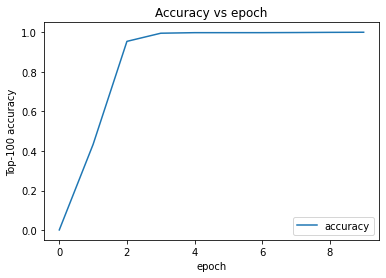

In [16]:
# num_validation_runs = len(one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [i for i in range(10)]

plt.plot(epochs, model_hist.history["factorized_top_k/top_100_categorical_accuracy"], label="accuracy")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

In [17]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# recommends items out of the entire dataset.
index.index(items.batch(100).map(model.item_model), items)

# Get recommendations.
j = str(40)
_, items = index(tf.constant([j]))
print(f"Recommendations for user %s: {items[0]}" %(j))

Recommendations for user 40: [b'housewares_1189' b'housewares_1181' b'housewares_1186'
 b'housewares_1188' b'electronics_1206' b'housewares_1185'
 b'housewares_1190' b'electronics_1205' b'housewares_1182'
 b'housewares_1184']


There you are, our first simple yet effective recommendation engine using retrieval task. But what about ranking? can we rank all the items for best to worst, only then run retrieval task to retrieve selected items from the short list? Now we can explore another type of recommendation task: ranking.

## Ranking Model

Ranking model is able to assist retrieval by ranking all the items from highest to lowest, predcting a probablity that a user may or may not like it. Ranking model is useful to filter out items that are not relevant for the user before retrieval task, making retrieval task much more accurate and efficient.

Here, many embedding layers works similarly with retrieval model, with addition of multiple hidden layers under Sequential latyers, where we can stack multiple dense layers. We split the query and candidate tower separately, and call them later into the model.

In [19]:
class RankingModel(tf.keras.Model):

    def __init__(self):
        super().__init__()
        embedding_dimension = 32

        # Compute embeddings for users.
        self.user_embeddings = tf.keras.Sequential([
          tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
          tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
        ])

        # Compute embeddings for movies.
        self.item_embeddings = tf.keras.Sequential([
          tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=unique_item_titles, mask_token=None),
          tf.keras.layers.Embedding(len(unique_item_titles) + 1, embedding_dimension)
        ])

        # Compute predictions.
        self.ratings = tf.keras.Sequential([
          # Learn multiple dense layers.
          tf.keras.layers.Dense(256, activation="relu"),
          tf.keras.layers.Dense(64, activation="relu"),
          # Make rating predictions in the final layer.
          tf.keras.layers.Dense(1)
  ])

    def call(self, inputs):

        user_id, item_id = inputs

        user_embedding = self.user_embeddings(user_id)
        item_embedding = self.item_embeddings(item_id)

        return self.ratings(tf.concat([user_embedding, item_embedding], axis=1))

This model takes user ids and item ids, and outputs a predicted rating, for example:

In [22]:
RankingModel()((["f6dd3ec061db4e3987629fe6b26e5cce"], ["pet_shop_0"]))

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.01409375]], dtype=float32)>

In [23]:
class RetailModel(tfrs.models.Model):

    def __init__(self):
        super().__init__()
        self.ranking_model: tf.keras.Model = RankingModel()
        self.task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
          loss = tf.keras.losses.MeanSquaredError(),
          metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        rating_predictions = self.ranking_model(
            (features["USERID"], features["ITEMID"]))

        # The task computes the loss and the metrics.
        return self.task(labels=features["RATING"], predictions=rating_predictions)

In [24]:
model = RetailModel()

model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.5))

cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

model.fit(cached_train, epochs=100)

Epoch 1/100
8/8 [==============================] - 3s 31ms/step - root_mean_squared_error: 0.9951 - loss: 0.8617 - regularization_loss: 0.0000e+00 - total_loss: 0.8617
Epoch 2/100
8/8 [==============================] - 0s 16ms/step - root_mean_squared_error: 0.2813 - loss: 0.0668 - regularization_loss: 0.0000e+00 - total_loss: 0.0668
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - root_mean_squared_error: 0.0593 - loss: 0.0030 - regularization_loss: 0.0000e+00 - total_loss: 0.0030
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - root_mean_squared_error: 0.0126 - loss: 1.3481e-04 - regularization_loss: 0.0000e+00 - total_loss: 1.3481e-04
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - root_mean_squared_error: 0.0027 - loss: 6.1202e-06 - regularization_loss: 0.0000e+00 - total_loss: 6.1202e-06
Epoch 6/100
8/8 [==============================] - 0s 14ms/step - root_mean_squared_error: 5.7347e-04 - loss: 2.7786e-07 - regularization_loss: 

In [25]:
model.evaluate(cached_test, return_dict=True)

5/5 [==============================] - 2s 22ms/step - root_mean_squared_error: 1.1921e-07 - loss: 1.4211e-14 - regularization_loss: 0.0000e+00 - total_loss: 1.4211e-14


{'loss': 1.4210854715202004e-14,
 'regularization_loss': 0,
 'root_mean_squared_error': 1.1920928955078125e-07,
 'total_loss': 1.4210854715202004e-14}

The RMSE is not very good, which we shall see how we can improve it by adding more features and combining ranking and retrieval model together.

## Adding Context
Adding Timestamp and Text embeddings

In [39]:
interactions_dict = df1.groupby(['USERID', 'ITEMID', 'TIMESTAMP'])['RATING'].count().reset_index()
interactions_dict = {name: np.array(value) for name, value in interactions_dict.items()}
interactions = tf.data.Dataset.from_tensor_slices(interactions_dict)

for x in interactions.take(5): print(x)

interactions = interactions.map(lambda x: {
    'USERID' : x['USERID'], 
    'ITEMID' : x['ITEMID'], 
    'RATING' : float(x['RATING']),
    'TIMESTAMP' : x['TIMESTAMP'],
})

{'USERID': <tf.Tensor: shape=(), dtype=string, numpy=b'00012a2ce6f8dcda20d059ce98491703'>, 'ITEMID': <tf.Tensor: shape=(), dtype=string, numpy=b'toys_1531'>, 'TIMESTAMP': <tf.Tensor: shape=(), dtype=float64, numpy=1510675706.0>, 'RATING': <tf.Tensor: shape=(), dtype=int64, numpy=1>}
{'USERID': <tf.Tensor: shape=(), dtype=string, numpy=b'000161a058600d5901f007fab4c27140'>, 'ITEMID': <tf.Tensor: shape=(), dtype=string, numpy=b'health_beauty_6074'>, 'TIMESTAMP': <tf.Tensor: shape=(), dtype=float64, numpy=1500198032.0>, 'RATING': <tf.Tensor: shape=(), dtype=int64, numpy=1>}
{'USERID': <tf.Tensor: shape=(), dtype=string, numpy=b'0001fd6190edaaf884bcaf3d49edf079'>, 'ITEMID': <tf.Tensor: shape=(), dtype=string, numpy=b'baby_571'>, 'TIMESTAMP': <tf.Tensor: shape=(), dtype=float64, numpy=1488280003.0>, 'RATING': <tf.Tensor: shape=(), dtype=int64, numpy=1>}
{'USERID': <tf.Tensor: shape=(), dtype=string, numpy=b'0002414f95344307404f0ace7a26f1d5'>, 'ITEMID': <tf.Tensor: shape=(), dtype=string, num

In [40]:
items_dict = df1[['ITEMID']].drop_duplicates()
items_dict = {name: np.array(value) for name, value in items_dict.items()}
items = tf.data.Dataset.from_tensor_slices(items_dict)

items = items.map(lambda x: x['ITEMID'])

timestamp is an exmaple of continuous features, which needs to be rescaled, or otherwise it will be too large for the model. there are other methods to reduce the size of the timestamp, ,such as standardization and normalization here we use discretization, which puts them into buckets of categorical features,

In [41]:
timestamps = np.concatenate(list(interactions.map(lambda x: x["TIMESTAMP"]).batch(100)))
max_timestamp = timestamps.max()
min_timestamp = timestamps.min()
timestamp_buckets = np.linspace(
    min_timestamp, max_timestamp, num=1000,)

item_ids = interactions.batch(10_000).map(lambda x: x["ITEMID"])
user_ids = interactions.batch(10_000).map(lambda x: x["USERID"])

unique_item_ids = np.unique(np.concatenate(list(item_ids)))
unique_user_ids = np.unique(np.concatenate(list(user_ids)))

In [42]:
tf.random.set_seed(42)
shuffled = interactions.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(60_000)
test = shuffled.skip(60_000).take(20_000)

cached_train = train.shuffle(100_000).batch(2048)
cached_test = test.batch(4096).cache()

We split the query and candidate model separately to allow more stacked embedding layers before we pass it into the model. In the user model (query model), in addition to user embedding, we also add timestamp embedding.

In [43]:
### user model

class UserModel(tf.keras.Model):

    def __init__(self, use_timestamps):
        super().__init__()

        self._use_timestamps = use_timestamps

        ## embed user id from unique_user_ids
        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(
                vocabulary=unique_user_ids, mask_token=None),
            tf.keras.layers.Embedding(len(unique_user_ids) + 1, 32),
        ])

        ## embed timestamp
        if use_timestamps:
            self.timestamp_embedding = tf.keras.Sequential([
              tf.keras.layers.experimental.preprocessing.Discretization(timestamp_buckets.tolist()),
              tf.keras.layers.Embedding(len(timestamp_buckets) + 1, 32),
            ])
            self.normalized_timestamp = tf.keras.layers.experimental.preprocessing.Normalization()

            self.normalized_timestamp.adapt(timestamps)

    def call(self, inputs):
        if not self._use_timestamps:
              return self.user_embedding(inputs["USERID"])

        ## all features here
        return tf.concat([
            self.user_embedding(inputs["USERID"]),
            self.timestamp_embedding(inputs["TIMESTAMP"]),
            self.normalized_timestamp(inputs["TIMESTAMP"]),
        ], axis=1)

For the candidate model, we want the model to learn from the text features too by processing the text features that is able to learn words that are similar to each other. It can also identify OOV (out of Vocabulary) word, so if we are predicing a new item, the model can calculate them appropriately.

Below, the item name will be transformated by tokenization (splitting into constituent words or word-pieces), followed by vocabulary learning, then followed by an embedding.



In [44]:
### candidate model

class ItemModel(tf.keras.Model):

    def __init__(self):
        super().__init__()

        max_tokens = 10_000

        ## embed title from unique_item_ids
        self.title_embedding = tf.keras.Sequential([
          tf.keras.layers.experimental.preprocessing.StringLookup(
              vocabulary=unique_item_ids, mask_token=None),
          tf.keras.layers.Embedding(len(unique_item_ids) + 1, 32)
        ])

        ## processing text features: item title vectorizer (see self.title_vectorizer)
        self.title_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
            max_tokens=max_tokens)

        ## we apply title vectorizer to items
        self.title_text_embedding = tf.keras.Sequential([
          self.title_vectorizer,
          tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
          tf.keras.layers.GlobalAveragePooling1D(),
        ])

        self.title_vectorizer.adapt(items)

    def call(self, titles):
        return tf.concat([
            self.title_embedding(titles),
            self.title_text_embedding(titles),
        ], axis=1)

With both UserModel and ItemModel defined, we can put together a combined model and implement our loss and metrics logic.

Note that we also need to make sure that the query model and candidate model output embeddings of compatible size. Because we'll be varying their sizes by adding more features, the easiest way to accomplish this is to use a dense projection layer after each model:

In [45]:
class RetailModel(tfrs.models.Model):

    def __init__(self, use_timestamps):
        super().__init__()
        
        ## query model is user model
        self.query_model = tf.keras.Sequential([
          UserModel(use_timestamps),
          tf.keras.layers.Dense(32)
        ])
        
        ## candidate model is the item model
        self.candidate_model = tf.keras.Sequential([
          ItemModel(),
          tf.keras.layers.Dense(32)
        ])
        
        ## retrieval task, choose metrics
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=items.batch(128).map(self.candidate_model),
            ),
        )

    def compute_loss(self, features, training=False):
        # We only pass the user id and timestamp features into the query model. This
        # is to ensure that the training inputs would have the same keys as the
        # query inputs. Otherwise the discrepancy in input structure would cause an
        # error when loading the query model after saving it.
        
        query_embeddings = self.query_model({
            "USERID": features["USERID"],
            "TIMESTAMP": features["TIMESTAMP"],
        })
        
        item_embeddings = self.candidate_model(features["ITEMID"])

        return self.task(query_embeddings, item_embeddings)

> Note: Baseline is with no timestamp feature.

In [47]:
model = RetailModel(use_timestamps=False)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))
model.fit(cached_train, epochs=3)

Epoch 1/3
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
30/30 [==============================] - 422s 14s/step - factorized_top_k/top_1_categorical_accuracy: 0.0564 - factorized_top_k/top_5_categorical_accuracy: 0.0614 - factorized_top_k/top_10_categorical_accuracy: 0.0640 - factorized_top_k/top_50_categorical_accuracy: 0.0715 - factorized_top_k/top_100_categorical_accuracy: 0.0752 - loss: 14855.2315 - regularization_loss: 0.0000e+00 - total_loss: 14855.2315
Epoch 2/3
30/30 [==============================] - 420s 14s/step - factorized_top_k/top_1_categorical_accuracy: 0.0479 - factorized_top_k/top_5_categorical_accuracy: 0.0490 - factorized_top_k/top_10_categorical_accuracy: 0.0495 - factorized_top_k/top_50_categorical_accuracy: 0.0508 - factorized_top_k/top_100_categorical_accuracy: 0.0516 - loss: 14047.4312 - regularization_loss: 0.0000e+00 - total_loss: 14047.4312
Epoch 3/3
30/30 [==============================] - 422s 

In [48]:
model.evaluate(cached_test, return_dict=True)

Consider rewriting this model with the Functional API.
5/5 [==============================] - 137s 27s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 33116.2435 - regularization_loss: 0.0000e+00 - total_loss: 33116.2435


{'factorized_top_k/top_100_categorical_accuracy': 0.0,
 'factorized_top_k/top_10_categorical_accuracy': 0.0,
 'factorized_top_k/top_1_categorical_accuracy': 0.0,
 'factorized_top_k/top_50_categorical_accuracy': 0.0,
 'factorized_top_k/top_5_categorical_accuracy': 0.0,
 'loss': 30138.40234375,
 'regularization_loss': 0,
 'total_loss': 30138.40234375}

Including time into the model:

Do the result change if we add time features?

In [49]:
model =x RetailModel(use_timestamps=True)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))
model.fit(cached_train, epochs=3)

Epoch 1/3
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
30/30 [==============================] - 430s 14s/step - factorized_top_k/top_1_categorical_accuracy: 0.0077 - factorized_top_k/top_5_categorical_accuracy: 0.0166 - factorized_top_k/top_10_categorical_accuracy: 0.0228 - factorized_top_k/top_50_categorical_accuracy: 0.0459 - factorized_top_k/top_100_categorical_accuracy: 0.0664 - loss: 14859.7737 - regularization_loss: 0.0000e+00 - total_loss: 14859.7737
Epoch 2/3
30/30 [==============================] - 430s 14s/step - factorized_top_k/top_1_categorical_accuracy: 2.1667e-04 - factorized_top_k/top_5_categorical_accuracy: 6.6667e-04 - factorized_top_k/top_10_categorical_accuracy: 0.0011 - factorized_top_k/top_50_categorical_accuracy: 0.0032 - factorized_top_k/top_100_categorical_accuracy: 0.0051 - loss: 12473.8825 - regularization_loss: 0.0000e+00 - total_loss: 12473.8825
Epoch 3/3
30/30 [==============================]

In [50]:
model.evaluate(cached_test, return_dict=True)

Consider rewriting this model with the Functional API.
5/5 [==============================] - 138s 27s/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 33796.7786 - regularization_loss: 0.0000e+00 - total_loss: 33796.7786


{'factorized_top_k/top_100_categorical_accuracy': 0.0,
 'factorized_top_k/top_10_categorical_accuracy': 0.0,
 'factorized_top_k/top_1_categorical_accuracy': 0.0,
 'factorized_top_k/top_50_categorical_accuracy': 0.0,
 'factorized_top_k/top_5_categorical_accuracy': 0.0,
 'loss': 30721.021484375,
 'regularization_loss': 0,
 'total_loss': 30721.021484375}

> Note: Eventhough we only run it at three epochs, we can see accuracy increase as we add time into the model.

## Multi-Task Model with ReLU-based DNN

The new component here is that - since we have two tasks and two losses - we need to decide on how important each loss is. We can do this by giving each of the losses a weight, and treating these weights as hyperparameters. If we assign a large loss weight to the rating task, our model is going to focus on predicting ratings (but still use some information from the retrieval task); if we assign a large loss weight to the retrieval task, it will focus on retrieval instead.

In [53]:
class Model(tfrs.models.Model):

    def __init__(self,
                 rating_weight: float, retrieval_weight: float) -> None:
        # We take the loss weights in the constructor: this allows us to instantiate
        # several model objects with different loss weights.

        super().__init__()

        embedding_dimension = 32

        # item models.
        self.item_model: tf.keras.layers.Layer = tf.keras.Sequential([
          tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=unique_item_ids, mask_token=None),
          tf.keras.layers.Embedding(len(unique_item_ids) + 1, embedding_dimension)
        ])
            
        ## user model    
        self.user_model: tf.keras.layers.Layer = tf.keras.Sequential([
          tf.keras.layers.experimental.preprocessing.StringLookup(
            vocabulary=unique_user_ids, mask_token=None),
          tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
        ])

        # A small model to take in user and item embeddings and predict ratings.
        # We can make this as complicated as we want as long as we output a scalar
        # as our prediction.
        
        ## this is Relu-Based DNN
        self.rating_model = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(1),
        ])

        # rating and retrieval task.
        self.rating_task: tf.keras.layers.Layer = tfrs.tasks.Ranking(
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )
            
        self.retrieval_task: tf.keras.layers.Layer = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=items.batch(128).map(self.item_model)
            )
        )

        # The loss weights.
        self.rating_weight = rating_weight
        self.retrieval_weight = retrieval_weight

    def call(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:
        # We pick out the user features and pass them into the user model.
        user_embeddings = self.user_model(features["USERID"])
        
        # And pick out the item features and pass them into the item model.
        item_embeddings = self.item_model(features["ITEMID"])

        return (
            user_embeddings,
            item_embeddings,
            # We apply the multi-layered rating model to a concatentation of
            # user and item embeddings.
            self.rating_model(
                tf.concat([user_embeddings, item_embeddings], axis=1)
            ),
        )

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:

        ## ratings go here as a method to compute loss
        ratings = features.pop("RATING")

        user_embeddings, item_embeddings, rating_predictions = self(features)

        # We compute the loss for each task.
        rating_loss = self.rating_task(
            labels=ratings,
            predictions=rating_predictions,
        )
        retrieval_loss = self.retrieval_task(user_embeddings, item_embeddings)

        # And combine them using the loss weights.
        return (self.rating_weight * rating_loss
                + self.retrieval_weight * retrieval_loss)

### Rating-specialized model
Depending on the weights we assign, the model will encode a different balance of the tasks. Let's start with a model that only considers ratings.

In [54]:
model = Model(rating_weight=1.0, retrieval_weight=0.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

model.fit(cached_train, epochs=3)
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/3
8/8 [==============================] - 388s 48s/step - root_mean_squared_error: 0.4401 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 6.6667e-05 - factorized_top_k/top_10_categorical_accuracy: 1.0000e-04 - factorized_top_k/top_50_categorical_accuracy: 4.5000e-04 - factorized_top_k/top_100_categorical_accuracy: 7.8333e-04 - loss: 0.1581 - regularization_loss: 0.0000e+00 - total_loss: 0.1581
Epoch 2/3
8/8 [==============================] - 385s 47s/step - root_mean_squared_error: 0.0205 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 6.6667e-05 - factorized_top_k/top_10_categorical_accuracy: 1.1667e-04 - factorized_top_k/top_50_categorical_accuracy: 4.5000e-04 - factorized_top_k/top_100_categorical_accuracy: 8.0000e-04 - loss: 3.7047e-04 - regularization_loss: 0.0000e+00 - total_loss: 3.7047e-04
Epoch 3/3
5/5 [==============================] - 133s 26s/step - root_

### Retrieval-specialized model
Let's now try a model that focuses on retrieval only.

In [55]:
model = Model(rating_weight=0.0, retrieval_weight=1.0)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

model.fit(cached_train, epochs=3)
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/3
8/8 [==============================] - 382s 47s/step - root_mean_squared_error: 0.9892 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 5.0000e-05 - factorized_top_k/top_10_categorical_accuracy: 6.6667e-05 - factorized_top_k/top_50_categorical_accuracy: 3.8333e-04 - factorized_top_k/top_100_categorical_accuracy: 7.0000e-04 - loss: 62067.1797 - regularization_loss: 0.0000e+00 - total_loss: 62067.1797
Epoch 2/3
8/8 [==============================] - 385s 47s/step - root_mean_squared_error: 0.9881 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0918 - factorized_top_k/top_10_categorical_accuracy: 0.1484 - factorized_top_k/top_50_categorical_accuracy: 0.3325 - factorized_top_k/top_100_categorical_accuracy: 0.4333 - loss: 61949.0569 - regularization_loss: 0.0000e+00 - total_loss: 61949.0569
Epoch 3/3
5/5 [==============================] - 130s 26s/step - root_mean_squ

### Joint model
Let's now train a model that assigns positive weights to both tasks.

In [56]:
model = Model(rating_weight=0.5, retrieval_weight=0.5)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

model.fit(cached_train, epochs=3)
metrics = model.evaluate(cached_test, return_dict=True)

print(f"Retrieval top-100 accuracy: {metrics['factorized_top_k/top_100_categorical_accuracy']:.3f}.")
print(f"Ranking RMSE: {metrics['root_mean_squared_error']:.3f}.")

Epoch 1/3
8/8 [==============================] - 383s 47s/step - root_mean_squared_error: 0.4693 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 1.6667e-05 - factorized_top_k/top_10_categorical_accuracy: 5.0000e-05 - factorized_top_k/top_50_categorical_accuracy: 2.6667e-04 - factorized_top_k/top_100_categorical_accuracy: 7.5000e-04 - loss: 31033.7246 - regularization_loss: 0.0000e+00 - total_loss: 31033.7246
Epoch 2/3
8/8 [==============================] - 387s 48s/step - root_mean_squared_error: 0.0133 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0084 - factorized_top_k/top_10_categorical_accuracy: 0.0152 - factorized_top_k/top_50_categorical_accuracy: 0.0466 - factorized_top_k/top_100_categorical_accuracy: 0.0706 - loss: 31004.2229 - regularization_loss: 0.0000e+00 - total_loss: 31004.2229
Epoch 3/3
5/5 [==============================] - 131s 26s/step - root_mean_squ

We can see that accuracy is highest and RMSE is lowest when we combine both ranking and retrieval together.